In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats.qmc as scp
from multiprocess import Pool

In [50]:
def monte_carlo(s, max_iter=300, sequence=None, sampling='random', np=np, scp=scp):
    """
    Perform single simulation for given parameters.
    
    Arguments:
    s -- sample size, must be an integer

    Keyword arguments:
    max_iter -- maximum number of iterations, must be an integer (default 300)
    sequence -- seed for independent rng, important when multiprocessing (default None)
    sampling -- string defining the employed sampling method, must be 'random', 'LHS', 'ortho', or 'importance'
    np -- numpy package, included to make imported numpy methods work in multiprocesses in .ipynb file, must not be changed
    scp -- scipy.stats.qmc methods, included to make imported scipy methods work in multiprocesses in .ipynb file, must not be changed
    """

    # Set uniform distribution boundaries
    real_min = -2
    real_max = 1
    im_min = -1.5
    im_max = 1.5

    width = real_max - real_min
    height = im_max - im_min

    # Set normal distribution values in case of importance sampling
    real_mean = -0.5
    real_std = 1
    im_mean = 0
    im_std = 1
    
    # Declare independent rng with supplied seed
    rng = np.random.default_rng(sequence)


    def generate_sample():
        """
        Generate a random sample of s complex numbers. Nested in monte_carlo() to make work with multiprocessing in .ipyb file.

        Returns Numpy array of size (s, 2). 
        """

        complex_arr = np.zeros(s, dtype=complex)

        if sampling == 'random':
            sample = rng.uniform(size=(s, 2))

        elif sampling == 'LHS':
            Latin = scp.LatinHypercube(d = 2, seed=rng)
            sample = Latin.random(n = s)

        elif sampling == 'ortho':
            sample = np.zeros((s, 2))
            Latin = scp.LatinHypercube(d = 2, seed=rng)
            current_index = 0
            if s < 1e4:
                spaces = 100
            else:
                spaces = 10000

            # Set initial sub space properties
            sub_s = int(round(s / spaces, 0))
            n = int(np.sqrt(spaces))
            sub_width = width / n
            sub_height = height / n

            sub_real_min = real_min
            sub_real_max = real_min + sub_width
            sub_im_max = im_max
            sub_im_min = im_max - sub_height

            # Sample equivalent regions in whole space from left right, top to bottom
            for vert_space in range(n):
                for hor_space in range(n):
                    sub_sample = Latin.random(n = sub_s)

                    # Place drawn sample in total sample
                    sample[current_index:(current_index + sub_s)] = scp.scale(sub_sample, [sub_real_min, sub_im_min], [sub_real_max, sub_im_max])

                    # Update horizontal boundaries for next horizontal subspace
                    sub_real_min = sub_real_max
                    sub_real_max += sub_width
                    current_index += sub_s
                
                # Update vertical boundaries for next vertical subspace
                sub_real_min = real_min
                sub_real_max = real_min + sub_width
                sub_im_max = sub_im_min
                sub_im_min -= sub_height

        elif sampling == 'importance':
            real_sample = rng.normal(real_mean, real_std, size=s)
            im_sample = rng.normal(im_mean, im_std, size=s)
            
        # Make drawn samples into complex array  
        if sampling != 'importance':
            try:
                sample = scp.scale(sample, [real_min, im_min], [real_max, im_max])
            except ValueError:
                # Thi only happens for orthogonal sampling, when sample is already scaled
                pass
            for i in range(s):    
                complex_arr[i] = complex(sample[i,0], sample[i,1])

        else:
            for i in range(s):
                complex_arr[i] = complex(real_sample[i], im_sample[i])
            
        return complex_arr


    def iterate(c):
        """
        Iterates complex number c from z = 0 under z = z**2 + c.

        Arguments:
        c -- complex number

        Returns iteration at which iterate() is aborted (int)
        """

        iter = 0
        z = 0
        while abs(z) <= 2 and iter < max_iter:
            z = z**2 + c
            iter += 1
        return iter

    def inv_Gaussian_distr(x, mean, std):
        """Returns inverted Gaussian distribution value for supplied x, mean, and std"""

        return (np.sqrt(2 * np.pi * std ** 2)) / np.exp(-(((x - mean) ** 2) / (2 * std ** 2)))

    # Make empty list with entry for each possible iteration value to save data
    iterations = []
    for j in range(max_iter):
        iterations.append([])

    # Generate set of complex numbers and iterate
    complex_list = generate_sample()
    for c in complex_list:
        iter = iterate(c)
        iterations[iter-1].append(c)

    # calculate area from fraction non-diverged points
    if sampling == 'importance':
        weights = inv_Gaussian_distr(np.real(iterations[-1]), real_mean, real_std) * inv_Gaussian_distr(np.imag(iterations[-1]), im_mean, im_std)
        A = sum(weights) / s

    else:
        A = (real_max - real_min) * (im_max - im_min) * len(iterations[-1])/ s
    
    return iterations, A

In [54]:
def visualise(data, max_iter):
    """
    Visualise the result of a simulation

    Arguments:
    data -- list of lists with complex coordinates
    max_iter -- maximum iteration that was allowed in the simulation
    """

    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111)

    # Normalise iteration range for the colourmap
    cmap = plt.cm.nipy_spectral_r
    norm = plt.Normalize(vmin=1, vmax=max_iter)

    plt.ylim(-1.2, 1.2)
    plt.xlim(-2, 1)

    i = 0
    # Scatter all complex points wih colour based on diverging iteration
    for it in data:
        i += 1
        x = np.real(np.array(it))
        y = np.imag(np.array(it))
        ax.scatter(x, y, lw=0, s=1*(72/fig.dpi)**2, color=cmap(norm(i)))

    plt.title('Visualisation of the Mandelbrot set')
    plt.xlabel('$Re_c$')
    plt.ylabel('$Im_c$')
    fig.savefig('mandelbrot.png', dpi=600)
    plt.show()

The following cell is used for declaring the variables $s$, $n$, and $i_{max}$ and perform the monte_carlo simulating function.

In [51]:
if __name__ == "__main__":

    # Initiate parameters, s is sample size, n denotes the amount of simulations
    s = 10000
    n = 10
    max_iter = 300
    max_iters = np.full(n, max_iter)
    s = np.full(n, s)

    # Create independent seeds for all parallel processes
    seq = np.random.SeedSequence()
    seeds = seq.spawn(n)

    # Create a list of n tuples containing all necessary arguments to propare multiprocessing
    args = list(zip(s, max_iters, seeds))
    results = []
    area = []

    # Simulate in parallel
    with Pool() as p:
        for result, A in p.starmap(monte_carlo, args):
            results.append(result)
            area.append(A)


    # convert results to single list for faster visualisation
    data = [None] * max_iter
    for subset in results:
        
        for it in range(len(subset)):
            try:
                data[it] += subset[it]
            except TypeError:
                data[it] = subset[it]

In [52]:
print(len(area))
print(np.mean(area))
print(np.std(area, ddof=1))

10
1.4981399999999998
0.044618785281538044


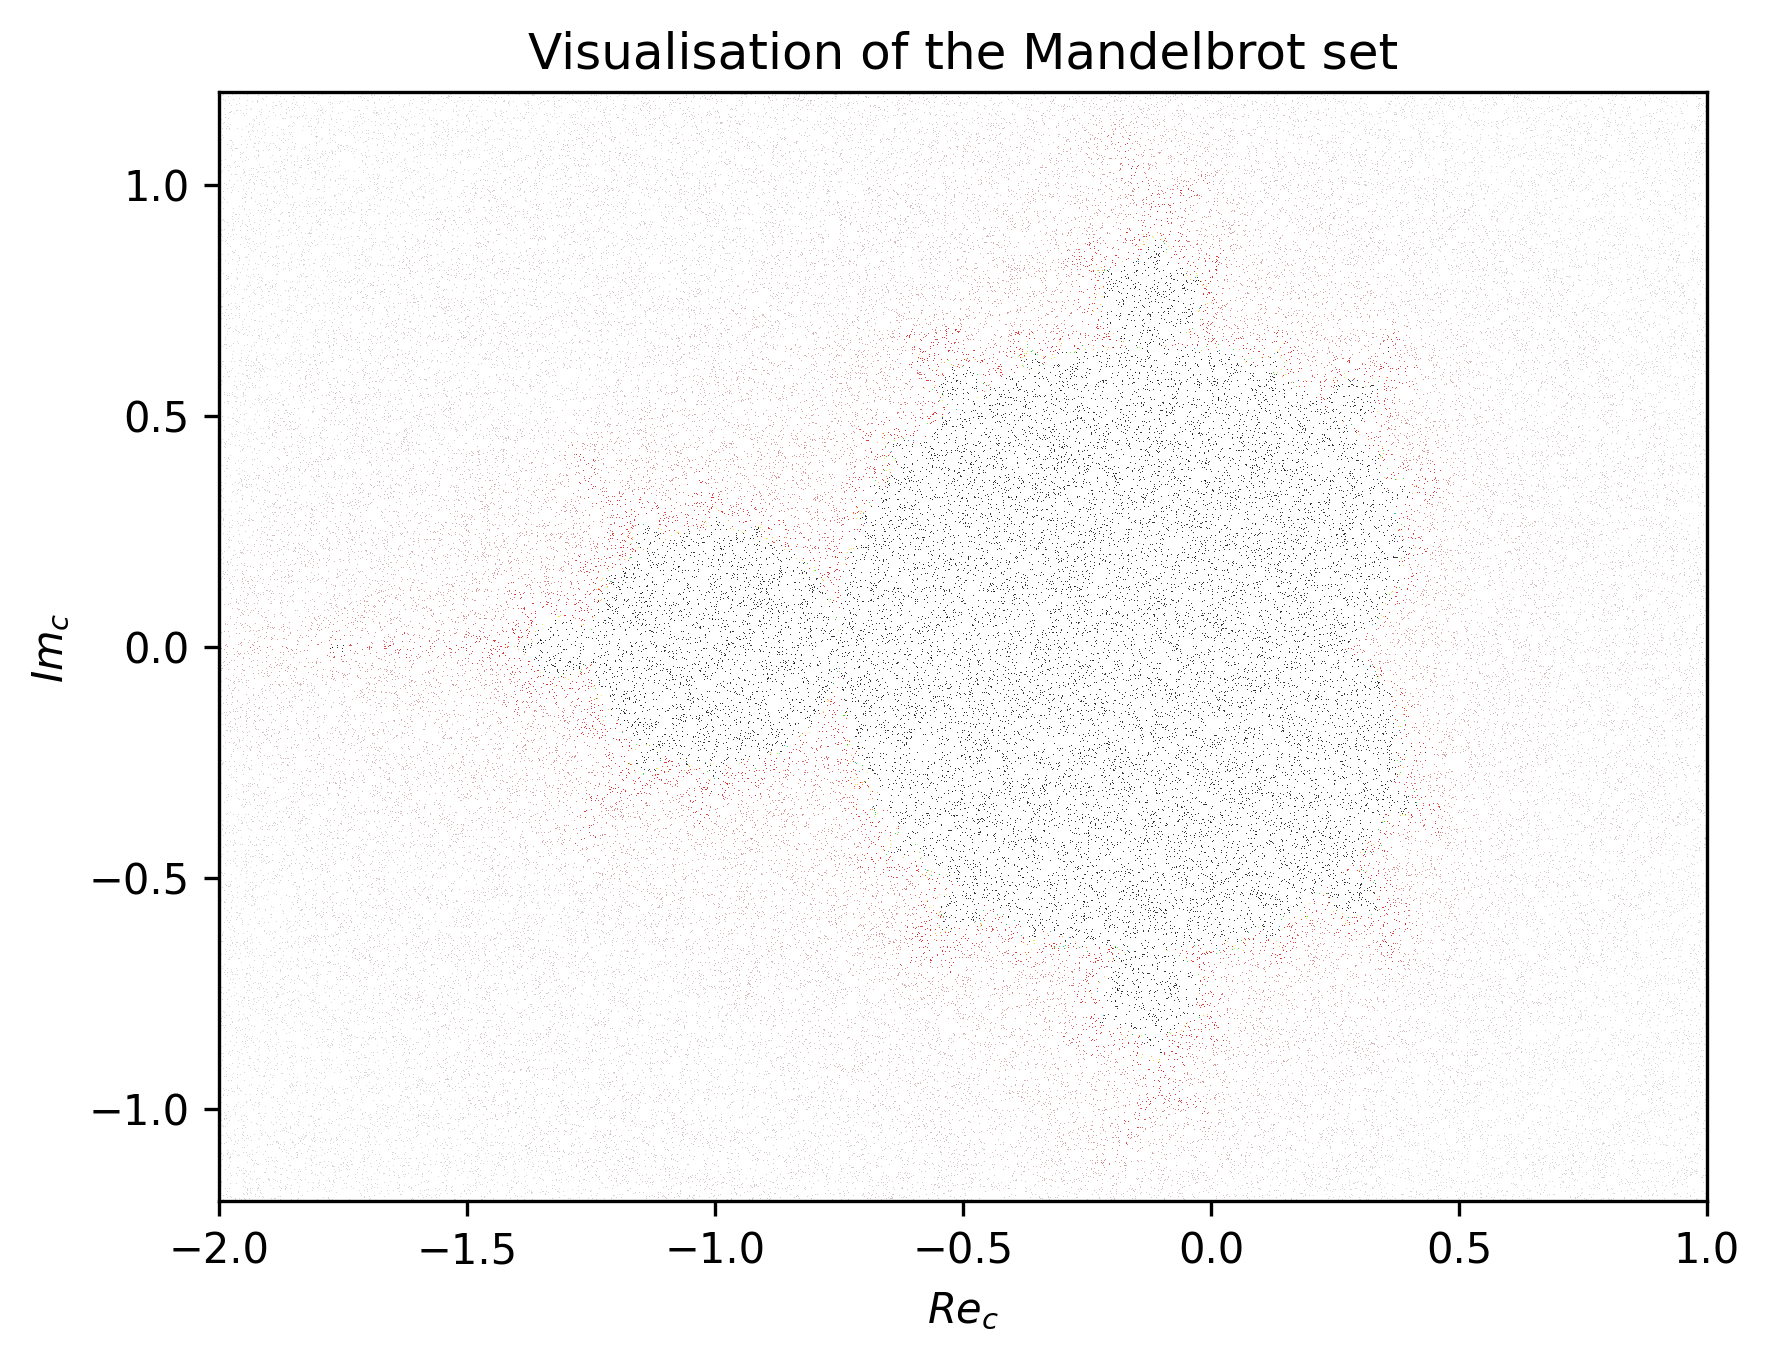

In [53]:
visualise(data, max_iter)

In [43]:
def converge_s(s_range, max_iter, sequence=None, sampling='random', monte_carlo=monte_carlo):
    """
    Perform the monte_carlo function over a range of s values
    
    Arguments:
    s_range -- the range of sample sizes to simulate,
    max_iter -- maximum amount of iterations to perform in amin function
    sequence -- seed for independent rng, important when multiprocessing (default None)
    sampling -- string defining the employed sampling method, must be 'random', 'LHS', 'ortho', or 'importance'
    monte_carlo -- monte_carlo function, included to make monte_carlo() method work in multiprocesses in .ipynb file, must not be changed
    
    Returns list of calculated areas
    """

    data = []
    child_sequence = sequence.spawn(len(s_range))
    
    for i in range(len(s_range)):
        s = s_range[i]
        iterations, A = monte_carlo(s, max_iter, child_sequence[i], sampling)
        data.append((s, A))
    
    return data

In [44]:
def converge_i(s, i_range, sequence=None, sampling='random', monte_carlo=monte_carlo):
    """
    Perform the monte_carlo function over a range of i_max values
    
    Arguments:
    s -- sample size,
    i_range -- the range of i values to simulate
    sequence -- seed for independent rng, important when multiprocessing (default None)
    sampling -- string defining the employed sampling method, must be 'random', 'LHS', 'ortho', or 'importance'
    monte_carlo -- monte_carlo function, included to make monte_carlo() method work in multiprocesses in .ipynb file, must not be changed
    
    Returns list of calculated areas
    """
    data = []
    child_sequence = sequence.spawn(len(i_range))
    
    for i in range(len(i_range)):
        max_iter = i_range[i]
        iterations, A = monte_carlo(s, max_iter, child_sequence[i], sampling)
        data.append((max_iter, A))
    
    return data

In [45]:
def analyse(results, var_range, variable, sampling='random', ):
    """
    Analyse results of ranged variables from converge methods

    Arguments:
    results -- list of simulation data
    var_range -- range of ranged variable
    variable -- string signifying the ranged variable, either 's' or 'i'
    sampling -- string signifying the employed sampling method, default 'random'
    """

    colours = {'random': 'blue', 'LHS': 'green', 'ortho': 'orange', 'importance': 'red'}

    data = np.zeros((len(results), 4))

    for sim in range(len(results)):
        var = var_range[sim]
        mean_area = np.mean(results[sim])

        std = np.std(results[sim], ddof=1)  
        differ = 1.96 * std / (np.sqrt(len(results[sim])))
        data[sim] = [var, mean_area, std, differ]

    fig = plt.figure(figsize=(4,3), dpi=300)
    x = data[:,0]
    y = data[:,1]
    yerr = data[:,-1]

    plt.plot(x, y, color = 'k')
    plt.fill_between(x, y - yerr, y + yerr, color=colours[sampling], alpha=0.3)

    if variable == 's':
        plt.xscale('log')
        plt.xlabel('Number of Samples')
    elif variable == 'i':

        plt.xlabel("Number of Iterations")
    
    plt.ylabel("Mean Area")
    plt.show()

    

The following cell is used for executing the converge_s function after declaring $n$, $i_{max}$ and an $s$ range through a minimum and a maximum $s$ (logarithmic in this case). If a sampling method other than random is needed it should also be declared ('random', 'LHS', 'ortho', or 'importance'). If the orthogonal sampling method is employed, all $s$ should by divisible by 100 if $s <10,000$, and divisible by 10,000 if $s \ge 10,000$ for correct results.

In [46]:
if __name__ == "__main__":

    # Initiate parameters
    min_log_s = 2
    max_log_s = 4
    steps = 3
    n = 10

    s_range = np.logspace(min_log_s, max_log_s, steps, dtype=int)
    s_ranges = np.repeat([s_range], n, axis=0)

    max_iter = 200
    max_iters = np.full(n, max_iter)

    sample_method = 'random'
    sample_methods = np.full(n, sample_method)

    # independent seeds necessary for parallel processing
    seq = np.random.SeedSequence()
    sequences = seq.spawn(n)
    
    # Create a list of n tuples containing all necessary arguments to propare multiprocessing
    args = list(zip(s_ranges, max_iters, sequences, sample_methods))

    # Simulate in parallel
    with Pool() as p:
        results =  np.array(p.starmap(converge_s, args))
    
    # Convert list of lists returned by multiprocessing into one list for faster analysis/visualisation
    s_data = [None] * steps
    for step in range(steps):
        s_data[step] = results[:,step, 1]



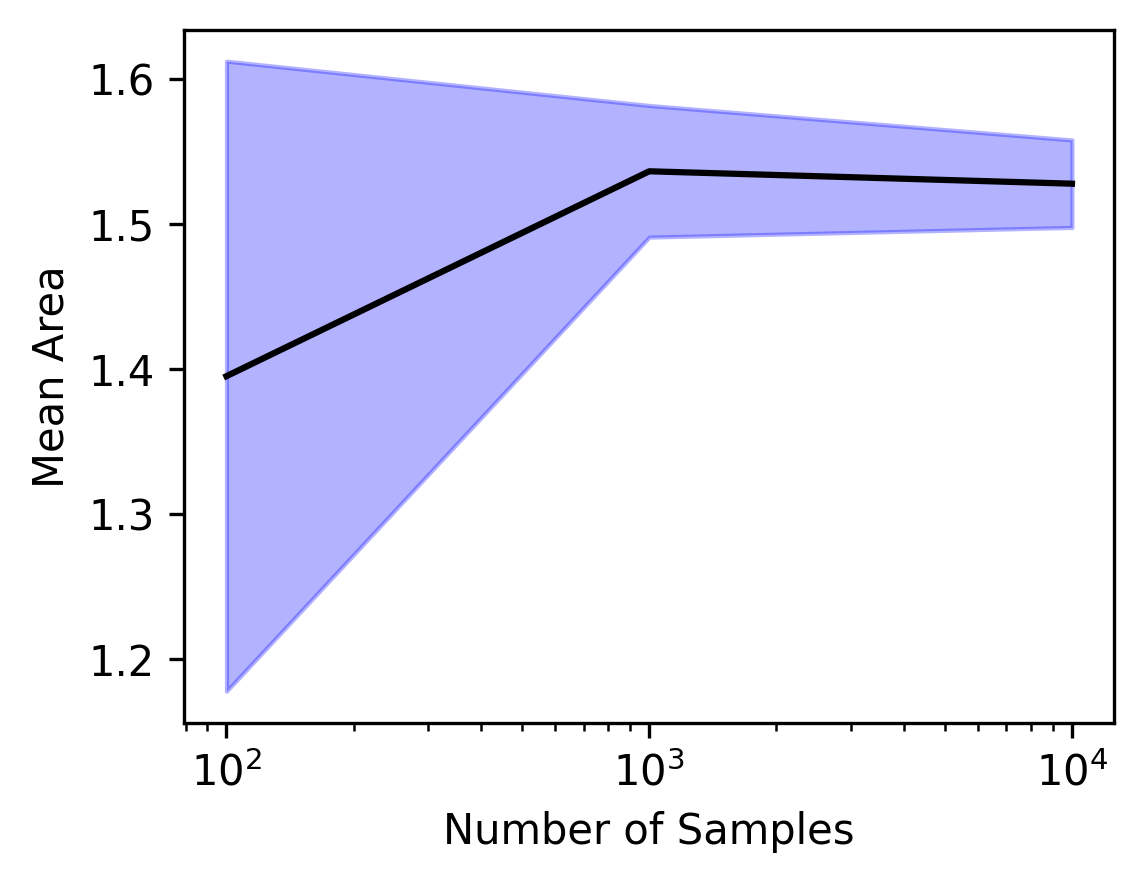

In [47]:
# Analyse separately separate from simulating
analyse(s_data, s_range, 's', sample_method)

The following cell is used for executing the converge_i function after declaring $s$, $n$ and an $i_{max}$ range through a minimum and a maximum $i_{max}$, and an amount of steps. If a sampling method other than random is needed it should also be declared ('random', 'LHS', 'ortho', or 'importance'). If the orthogonal sampling method is employed, all $s$ should by divisible by 100 if $s <10,000$, and divisible by 10,000 if $s \ge 10,000$ for correct results.

In [48]:
if __name__ == "__main__":
    s = 1000
    
    n = 10
    
    min_iter = 100
    max_iter = 1000
    steps = 2

    
    max_iters = np.full(n, max_iter)
    s_list = np.full(n, s)

    iter_range = np.linspace(min_iter, max_iter, steps, dtype=int)
    iter_ranges = np.repeat([iter_range], n, axis=0)

    sample_method = 'importance'
    sample_methods = np.full(n, sample_method)

    # independent seeds necessary for parallel processing
    seq = np.random.SeedSequence()
    sequences = seq.spawn(n)
    
    args = list(zip(s_list, iter_ranges, sequences))
    
    with Pool() as p:
        results =  np.array(p.starmap(converge_i, args))
    
    i_data = [None] * steps
    for step in range(steps):
        i_data[step] = results[:,step, 1]

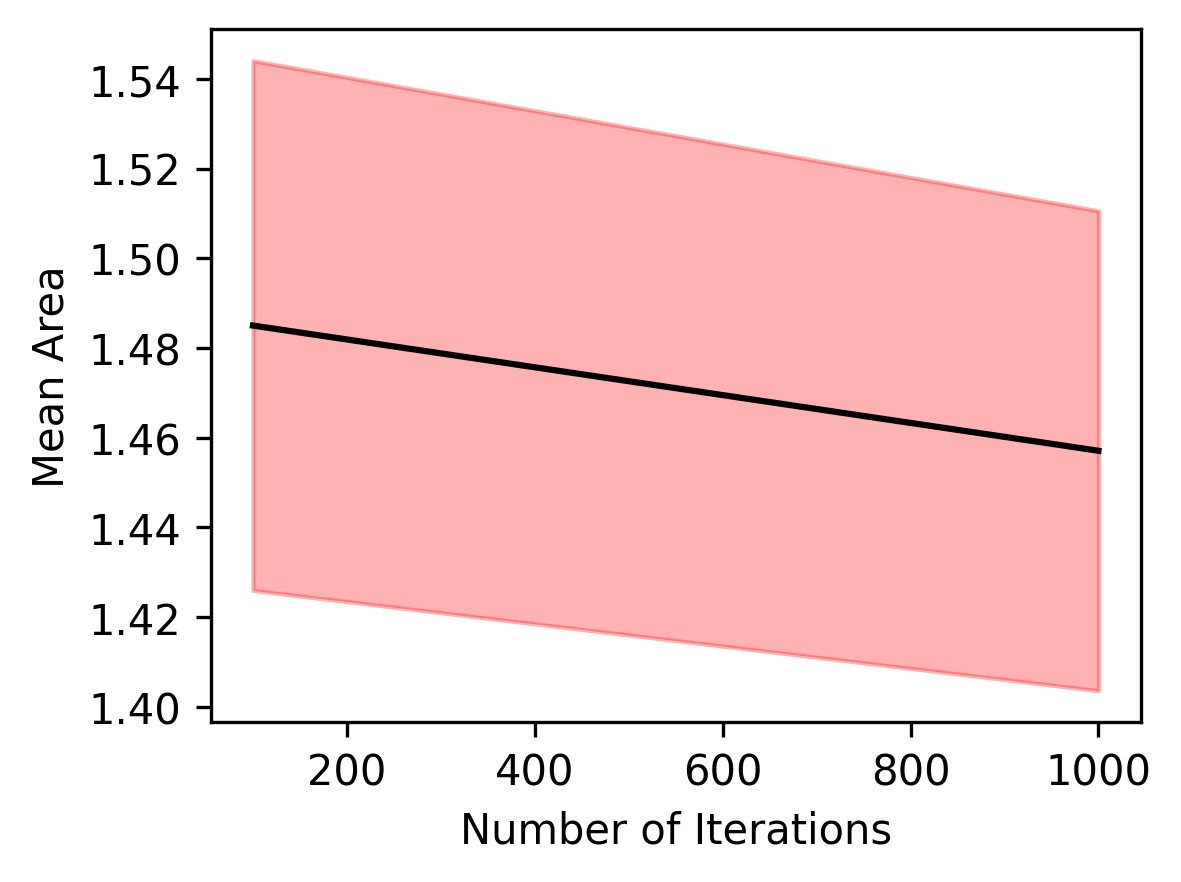

In [49]:
analyse(i_data, iter_range, 'i',sample_method)